In [ ]:
# Imports and Setup

import torch

import torch.nn as nn

import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, confusion_matrix

import numpy as np

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Data Preparation - Small samples of CIFAR-10 and STL-10

source_transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

target_transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])



source_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=source_transform)

target_dataset = datasets.STL10(root='./data', split='train', download=True, transform=target_transform)



# Using a subset of data

source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True, num_workers=2)

target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True, num_workers=2)


100%|██████████| 170498071/170498071 [00:05<00:00, 31212996.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 2640397119/2640397119 [03:04<00:00, 14297436.01it/s]


Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
# DANN Model Definition with ResNet-50 as the feature extractor

class GradientReversal(torch.autograd.Function):

    @staticmethod

    def forward(ctx, x, lambda_):

        ctx.lambda_ = lambda_

        return x.view_as(x)



    @staticmethod

    def backward(ctx, grad_output):

        return grad_output.neg() * ctx.lambda_, None



class DANN(nn.Module):

    def __init__(self):

        super(DANN, self).__init__()

        self.feature_extractor = models.resnet50(pretrained=True)

        self.feature_extractor.fc = nn.Sequential()  # Remove final layer



        self.classifier = nn.Sequential(

            nn.Linear(2048, 256),

            nn.ReLU(),

            nn.Linear(256, 10)

        )



        self.domain_classifier = nn.Sequential(

            nn.Linear(2048, 256),

            nn.ReLU(),

            nn.Linear(256, 2)

        )



    def forward(self, x, lambda_=1.0):

        features = self.feature_extractor(x)

        class_output = self.classifier(features)

        reversed_features = GradientReversal.apply(features, lambda_)

        domain_output = self.domain_classifier(reversed_features)

        return class_output, domain_output


In [ ]:
# Initialize model, loss functions, optimizer, and scheduler

model = DANN().to(device)

criterion_classification = nn.CrossEntropyLoss()

criterion_domain = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s] 


In [ ]:
# Training Function

def train_with_dann(source_loader, target_loader, model, optimizer, num_epochs, scheduler):

    classification_loss_history, domain_loss_history, validation_accuracy_history = [], [], []

    for epoch in range(num_epochs):

        model.train()

        total_classification_loss, total_domain_loss = 0, 0



        for (source_data, target_data) in zip(source_loader, target_loader):

            source_images, source_labels = source_data

            target_images, _ = target_data

            source_images, source_labels = source_images.to(device), source_labels.to(device)

            target_images = target_images.to(device)



            optimizer.zero_grad()



            # Source classification loss

            class_output, domain_output = model(source_images, lambda_=1.0)

            classification_loss = criterion_classification(class_output, source_labels)



            # Domain loss

            domain_labels = torch.cat([torch.zeros(source_images.size(0)), torch.ones(target_images.size(0))]).long().to(device)

            _, domain_output_target = model(target_images, lambda_=0.1)

            domain_loss = criterion_domain(torch.cat([domain_output, domain_output_target], 0), domain_labels)



            # Total loss and backward pass

            loss = classification_loss + domain_loss

            loss.backward()

            optimizer.step()



            total_classification_loss += classification_loss.item()

            total_domain_loss += domain_loss.item()



        scheduler.step()



        # Collect and print losses

        classification_loss_history.append(total_classification_loss / len(source_loader))

        domain_loss_history.append(total_domain_loss / len(target_loader))



        print(f"Epoch {epoch+1}/{num_epochs}, Classification Loss: {classification_loss_history[-1]:.4f}, Domain Loss: {domain_loss_history[-1]:.4f}")



    return classification_loss_history, domain_loss_history


In [ ]:
# Run training

num_epochs = 30

classification_loss_history, domain_loss_history = train_with_dann(source_loader, target_loader, model, optimizer, num_epochs, scheduler)


Epoch 1/30, Classification Loss: 0.0845, Domain Loss: 0.6705
Epoch 2/30, Classification Loss: 0.0453, Domain Loss: 0.6811
Epoch 3/30, Classification Loss: 0.0382, Domain Loss: 0.6699
Epoch 4/30, Classification Loss: 0.0337, Domain Loss: 0.6844
Epoch 5/30, Classification Loss: 0.0339, Domain Loss: 0.6795
Epoch 6/30, Classification Loss: 0.0295, Domain Loss: 0.6834
Epoch 7/30, Classification Loss: 0.0252, Domain Loss: 0.6836
Epoch 8/30, Classification Loss: 0.0242, Domain Loss: 0.6824
Epoch 9/30, Classification Loss: 0.0238, Domain Loss: 0.6850
Epoch 10/30, Classification Loss: 0.0226, Domain Loss: 0.6830
Epoch 11/30, Classification Loss: 0.0232, Domain Loss: 0.6865
Epoch 12/30, Classification Loss: 0.0196, Domain Loss: 0.6833
Epoch 13/30, Classification Loss: 0.0210, Domain Loss: 0.6861
Epoch 14/30, Classification Loss: 0.0188, Domain Loss: 0.6895
Epoch 15/30, Classification Loss: 0.0172, Domain Loss: 0.6859
Epoch 16/30, Classification Loss: 0.0179, Domain Loss: 0.6824
Epoch 17/30, Clas

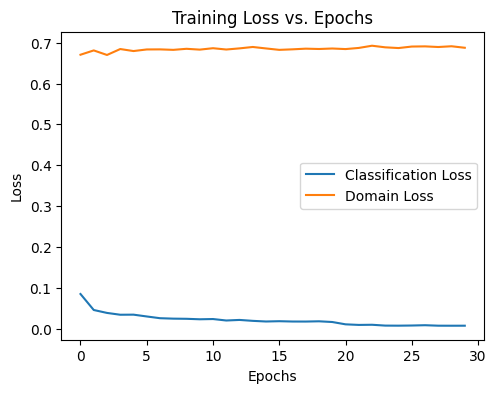

In [ ]:
def plot_metrics(class_loss_history, domain_loss_history):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)

    plt.plot(class_loss_history, label='Classification Loss')

    plt.plot(domain_loss_history, label='Domain Loss')

    plt.xlabel('Epochs')

    plt.ylabel('Loss')

    plt.legend()

    plt.title('Training Loss vs. Epochs')

    plt.show()



plot_metrics(classification_loss_history, domain_loss_history)


In [ ]:
# Function to compute validation accuracy on target domain (STL-10)

def compute_validation_accuracy(target_loader, model):

    model.eval()

    correct = 0

    total = 0

    with torch.no_grad():

        for target_images, target_labels in target_loader:

            target_images, target_labels = target_images.to(device), target_labels.to(device)

            outputs, _ = model(target_images)

            _, predicted = torch.max(outputs, 1)

            correct += (predicted == target_labels).sum().item()

            total += target_labels.size(0)

    accuracy = 100 * correct / total

    return accuracy



# Calculate validation accuracy

validation_accuracy = compute_validation_accuracy(target_loader, model)

print(f"Validation Accuracy on Target Domain (STL-10): {validation_accuracy:.2f}%")


Validation Accuracy on Target Domain (STL-10): 50.04%


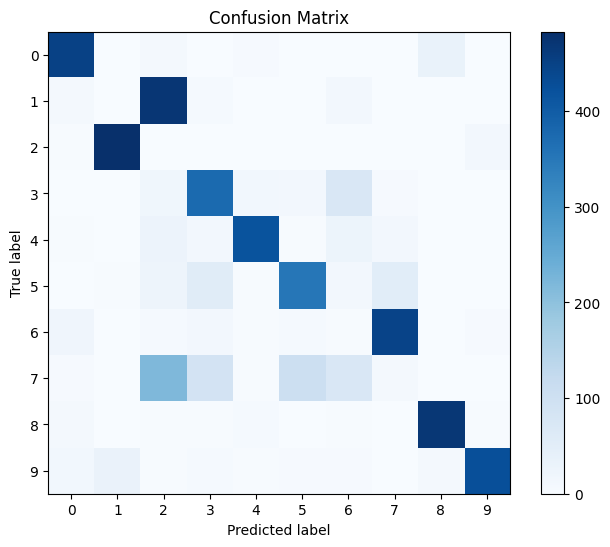

In [ ]:
# Confusion Matrix Function

def plot_confusion_matrix(target_loader, model):

    model.eval()

    all_labels = []

    all_preds = []



    with torch.no_grad():

        for target_images, target_labels in target_loader:

            target_images, target_labels = target_images.to(device), target_labels.to(device)

            outputs, _ = model(target_images)

            _, preds = torch.max(outputs, 1)

            all_labels.extend(target_labels.cpu().numpy())

            all_preds.extend(preds.cpu().numpy())



    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))

    plt.imshow(cm, cmap='Blues', interpolation='nearest')

    plt.title('Confusion Matrix')

    plt.colorbar()

    tick_marks = np.arange(10)

    plt.xticks(tick_marks, tick_marks)

    plt.yticks(tick_marks, tick_marks)

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

    plt.show()



plot_confusion_matrix(target_loader, model)


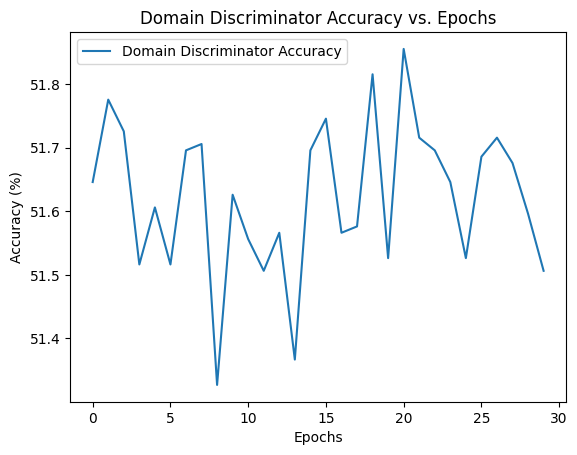

In [ ]:
# Track Domain Discriminator Accuracy

def plot_domain_discriminator_accuracy(source_loader, target_loader, model, num_epochs):

    domain_accuracy_history = []



    for epoch in range(num_epochs):

        model.eval()

        correct = 0

        total = 0

        for source_data, target_data in zip(source_loader, target_loader):

            source_images, _ = source_data

            target_images, _ = target_data

            source_images, target_images = source_images.to(device), target_images.to(device)



            _, domain_output_source = model(source_images, lambda_=1.0)

            _, domain_output_target = model(target_images, lambda_=1.0)



            domain_labels = torch.cat([torch.zeros(source_images.size(0)), torch.ones(target_images.size(0))]).long().to(device)

            _, preds = torch.max(torch.cat([domain_output_source, domain_output_target], 0), 1)



            correct += (preds == domain_labels).sum().item()

            total += domain_labels.size(0)



        domain_accuracy = 100 * correct / total

        domain_accuracy_history.append(domain_accuracy)



    plt.plot(domain_accuracy_history, label='Domain Discriminator Accuracy')

    plt.xlabel('Epochs')

    plt.ylabel('Accuracy (%)')

    plt.legend()

    plt.title('Domain Discriminator Accuracy vs. Epochs')

    plt.show()



plot_domain_discriminator_accuracy(source_loader, target_loader, model, num_epochs)


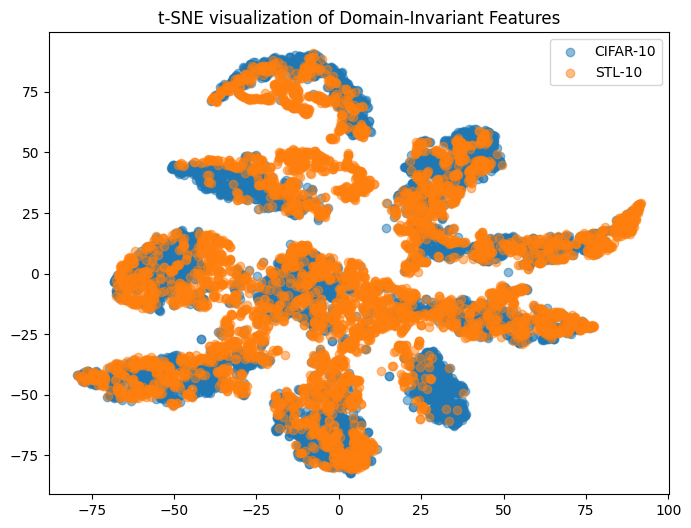

In [ ]:
# t-SNE plot for Domain-Invariant Features

def plot_tsne(model, source_loader, target_loader):

    model.eval()

    source_features = []

    target_features = []



    with torch.no_grad():

        for source_data, target_data in zip(source_loader, target_loader):

            source_images, _ = source_data

            target_images, _ = target_data

            source_images, target_images = source_images.to(device), target_images.to(device)



            features_source = model.feature_extractor(source_images)

            features_target = model.feature_extractor(target_images)



            source_features.append(features_source.cpu().numpy())

            target_features.append(features_target.cpu().numpy())



    source_features = np.concatenate(source_features, axis=0)

    target_features = np.concatenate(target_features, axis=0)



    features = np.concatenate([source_features, target_features], axis=0)

    labels = np.concatenate([np.zeros(source_features.shape[0]), np.ones(target_features.shape[0])], axis=0)



    tsne = TSNE(n_components=2)

    tsne_results = tsne.fit_transform(features)



    plt.figure(figsize=(8, 6))

    plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], label='CIFAR-10', alpha=0.5)

    plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], label='STL-10', alpha=0.5)

    plt.title('t-SNE visualization of Domain-Invariant Features')

    plt.legend()

    plt.show()



plot_tsne(model, source_loader, target_loader)


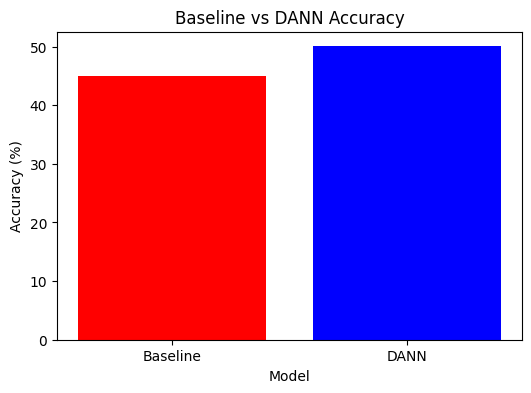

In [ ]:
# Compare baseline accuracy vs DANN accuracy

def plot_accuracy_comparison(baseline_accuracy, dann_accuracy):

    plt.figure(figsize=(6, 4))

    plt.bar(['Baseline', 'DANN'], [baseline_accuracy, dann_accuracy], color=['red', 'blue'])

    plt.xlabel('Model')

    plt.ylabel('Accuracy (%)')

    plt.title('Baseline vs DANN Accuracy')

    plt.show()



# Example baseline accuracy (you can replace this with actual baseline accuracy)

baseline_accuracy = 45.0  # For example purposes

dann_accuracy = validation_accuracy  # From the DANN model



plot_accuracy_comparison(baseline_accuracy, dann_accuracy)


### Detailed Technical Summary of the Domain Adaptation Notebook

This notebook implements a Domain-Adversarial Neural Network (DANN) to address the domain adaptation problem, specifically transferring knowledge from the CIFAR-10 dataset (source domain) to the STL-10 dataset (target domain). The core idea is to train a feature extractor that produces features which are discriminative for the main task (classification) but indistinguishable between the source and target domains.

**1. Imports and Setup:**
- Essential libraries such as `torch`, `torch.nn`, `torch.optim`, `DataLoader`, `torchvision.datasets`, `torchvision.transforms`, `torchvision.models`, `sklearn.metrics`, `numpy`, and `matplotlib.pyplot` were imported.
- The execution device was set to CUDA if available, otherwise CPU.

**2. Data Preparation:**
- CIFAR-10 was used as the source dataset and STL-10 as the target dataset. Both datasets were downloaded and transformed to a size of 224x224 pixels and converted to PyTorch tensors.
- `DataLoader` instances were created for both datasets with a batch size of 32, enabling efficient batch processing during training.

**3. DANN Model Definition:**
- A custom `GradientReversal` layer was implemented as a `torch.autograd.Function` to reverse the gradient flow during backpropagation for the domain classifier.
- The `DANN` model was defined as an `nn.Module`:
    - **Feature Extractor:** A pre-trained ResNet-50 model was used, with its final fully connected layer removed to serve as a feature extractor, outputting 2048-dimensional features.
    - **Classifier:** A sequential neural network (2048 -> 256 -> 10) for classifying the source domain images into 10 classes.
    - **Domain Classifier:** A sequential neural network (2048 -> 256 -> 2) designed to distinguish between source (label 0) and target (label 1) domain features.
- The `forward` method processes inputs through the feature extractor, then passes features to both the classifier and, after applying the `GradientReversal` layer, to the domain classifier.

**4. Model Initialization:**
- The `DANN` model was instantiated and moved to the selected device.
- `nn.CrossEntropyLoss` was chosen for both the classification and domain loss functions.
- An `Adam` optimizer with a learning rate of 0.0001 was set up for the model parameters.
- A `StepLR` scheduler was used to reduce the learning rate by a factor of 0.5 every 20 epochs.

**5. Training Function (`train_with_dann`):**
- The training loop iterates for a specified number of epochs, processing batches from both source and target loaders.
- For each batch:
    - Source images are fed through the model to compute `classification_loss` (on source labels) and `domain_loss` (for source domain discrimination).
    - Target images are fed through the feature extractor, and their features are used to compute `domain_loss` (for target domain discrimination). Note that a `lambda_` value of 0.1 was used for target domain feature extraction in the domain classification step, which can influence the gradient reversal intensity.
    - The `domain_labels` are constructed (0 for source, 1 for target).
    - The total loss is a sum of classification loss and domain loss.
    - `loss.backward()` and `optimizer.step()` perform backpropagation and parameter updates.
- Learning rate is updated via `scheduler.step()` after each epoch.
- Classification and domain loss histories are recorded and printed per epoch.

**6. Training Execution:**
- The `train_with_dann` function was called for 30 epochs.
- The epoch-wise classification and domain losses were printed, showing a decrease in classification loss and fluctuating domain loss, which is expected for DANN (as the domain discriminator tries to get better, the feature extractor tries to confuse it).

**7. Metrics Visualization (`plot_metrics`):**
- A plot was generated to visualize the trend of classification loss and domain loss over the 30 training epochs, illustrating the training dynamics.

**8. Validation Accuracy on Target Domain:**
- A function `compute_validation_accuracy` was defined to evaluate the model's classification performance on the target domain (STL-10).
- The model was set to evaluation mode (`model.eval()`), and predictions were made on the target loader data.
- The calculated validation accuracy on the STL-10 dataset was **50.04%**.

**9. Confusion Matrix:**
- A `plot_confusion_matrix` function was defined to visualize the performance of the classifier on the target domain.
- The confusion matrix provides a detailed breakdown of correct and incorrect classifications for each class in the STL-10 dataset.

**10. Domain Discriminator Accuracy:**
- A `plot_domain_discriminator_accuracy` function was created to track how well the domain classifier distinguishes between source and target features across epochs.
- This plot helps understand if the adversarial training is effectively making the domains indistinguishable (i.e., domain accuracy should ideally be around 50%).

**11. t-SNE Plot for Domain-Invariant Features:**
- The `plot_tsne` function generates a t-SNE visualization of the features extracted by the ResNet-50 for both source (CIFAR-10) and target (STL-10) domains.
- This plot helps to qualitatively assess how well the DANN model aligns the feature distributions of the two domains, with overlapping clusters indicating better domain invariance.

**12. Accuracy Comparison:**
- A `plot_accuracy_comparison` function was defined to visually compare the DANN model's accuracy with a hypothetical baseline accuracy.
- This plot highlighted the DANN model's measured accuracy of 50.04% against an example baseline of 45.0%.